In [343]:
import os 
import pandas as pd
import pandas as pd
import sqlalchemy as sa
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.engine.url import URL
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import sys
import boto3
import utils_schema
from utils_schema import get_otu_and_taxo
from scipy.stats import pearsonr
from scipy.stats import gmean
import statsmodels.api as sm


In [3]:
utils_schema


<module 'utils_schema' from '/Users/sebastianbedoyamazo/Google Drive/Mi unidad/siwa/iluma-kb/utils_schema.py'>

In [4]:
load_dotenv("/Users/sebastianbedoyamazo/Documents/Data-exploration-and-others/.env", override=True)

True

In [5]:
os.environ
import utils_schema
sys.path.append("/Users/sebastianbedoyamazo/Documents/Data-exploration-and-others")
import utils_dataexp as u


Reading aws keys from .env successfully!!


In [6]:
s3_client = boto3.client("s3")
s3_resource = boto3.resource("s3")


In [7]:
url = URL.create(
    drivername='redshift+redshift_connector',
    host='iluma-kb-1.cn4ff1ztoyt9.us-east-1.redshift.amazonaws.com',
    port=5439,
    database='dev',
    username='awsuser',
    password='Ilumasiwa1'
)

engine = create_engine(url)
Session = sessionmaker()
Session.configure(bind=engine)
session = Session()

redshift_metadata = sa.MetaData(bind=session.bind)



# Check functions  

In [8]:
def common_features(a, b):
    a = [element.lower() for element in a]
    b = [element.lower() for element in b]
    result = [i for i in a if i in b]
    return result


In [9]:
def merge_dataframes(df1, df2, merge_on):
    merged_df = df1.merge(df2, how='left', on=merge_on)
    return merged_df


# Feature and taxonomy from broiler experiments (267, 271, 321, 325, 326, 335, 345, 347

## Run where are those experimentos

### 20181130 (E267, E291), 
### 20210527 (E321, E325), 
### 20211206 (E326, E335), 
### 20211214 (E345, E347)

In [ ]:
s3_client.list_objects_v2(Bucket="siwamicrobiome", Prefix="exports/")["Contents"]


In [ ]:
s3_client.list_objects_v2(Bucket="siwamicrobiome", Prefix="exports/20210527")["Contents"]

In [ ]:
s3_client.list_objects_v2(Bucket="siwamicrobiome", Prefix="exports/20181130")["Contents"]

In [ ]:
s3_client.list_objects_v2(Bucket="siwamicrobiome", Prefix="exports/20211206")["Contents"]

In [ ]:
s3_client.list_objects_v2(Bucket="siwamicrobiome", Prefix="exports/20211214")["Contents"]

In [15]:
feat267_271 = u.read_csv_s3("exports/20181130/20181130.feature-table.tsv", "siwamicrobiome", sep="\t")
feat321_325 = u.read_csv_s3("exports/20210527/20210527.feature-table.tsv", "siwamicrobiome", sep="\t")
feat326_335 = u.read_csv_s3("exports/20211206/20211206.feature-table.tsv", "siwamicrobiome", sep="\t")
feat345 = u.read_csv_s3("exports/20211214/20211214.feature-table.tsv", "siwamicrobiome", sep="\t")


In [21]:
samples267_271 = list(feat267_271[[i for i in feat267_271.columns if "_" in i]].columns)
samples321_325 = list(feat321_325[[i for i in feat321_325.columns if "_" in i]].columns)
samples326_335 = list(feat326_335[[i for i in feat326_335.columns if "_" in i]].columns)
samples345 = list(feat345[[i for i in feat345.columns if "_" in i]].columns)

samples267_271.append("OTU")
samples321_325.append("OTU")
samples326_335.append("OTU")
samples345.append("OTU")



In [22]:
tax267_271 = u.read_csv_s3("exports/20181130/20181130.silva.taxonomy_processed.csv", "siwamicrobiome")
tax321_325 = u.read_csv_s3("exports/20210527/20210527.silva.taxonomy_processed.csv", "siwamicrobiome")
tax326_335 = u.read_csv_s3("exports/20211206/20211206.silva.taxonomy_processed.csv", "siwamicrobiome")
tax345 = u.read_csv_s3("exports/20211214/20211214.taxonomy_processed.csv", "siwamicrobiome")



otu345_347 = merge_dataframes(feat267_271, tax267_271, ['OTU'])
otu321_325 = merge_dataframes(feat321_325, tax321_325, ['OTU'])
otu326_335 = merge_dataframes(feat326_335, tax326_335, ['OTU'])
otu345_347 = merge_dataframes(feat345_347, tax345_347, ['OTU'])


In [338]:
otu_rel = u.convert_relative(feat345[samples345])
specie345 = u.aggregate_taxa("Species", tax345, otu_rel)
specie345.head(2)

OTUS are index


,0105_01C-M,0105_01F-M,0105_01I-M,0105_02C-M,0105_02F-M,0105_02I-M,0105_03C-M,0105_03F-M,0105_03I-M,0105_04C-M,...,0114_03I-M,0114_04C-M,0114_04F-M,0114_04I-M,0114_05C-M,0114_05F-M,0114_05I-M,0114_06C-M,0114_06F-M,0114_06I-M
UNKNOWN,0.905404,0.939832,0.810245,0.935116,0.966566,0.974769,0.953545,0.937756,0.91977,0.938675,...,0.82127,0.965702,0.865005,0.822836,0.966229,0.808874,0.78055,0.967871,0.95019,0.92547
bacterium_ic1277,0.001022,0.000000,0.000000,0.000446,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.001376,0.000000,0.00000,0.000000,0.00000,0.00000


In [254]:
specie345t = specie345.T
specie345t['fullsampleid'] = specie345t.index
specie345t = specie345t.reset_index(drop=True)

In [341]:
a = specie345+0.1 

In [342]:
df345_clr = np.log(a / gmean(a, axis=1)[:, np.newaxis])
df345_clr.head(1)
df345_clr_t = df345_clr.T
df345_clr_t['fullsampleid'] = df345_clr_t.index
df345_clr_t = df345_clr_t.reset_index(drop=True)
df345_clr_t

,UNKNOWN,bacterium_ic1277,Lactobacillus_aviarius,Bacteroides_plebeius,Peptostreptococcus_sp.,Enterococcus_cecorum,Lactobacillus_coleohominis,Helicobacter_pullorum,Lactobacillus_agilis,Prevotellaceae_bacterium,...,Bifidobacterium_subtile,Candidatus_Arthromitus,Trichoderma_gamsii,Rhabdanaerobium_thermarum,Algoriphagus_marincola,Turicimonas_muris,Prevotella_buccalis,Lactobacillus_vaginalis,Bdellovibrio_sp.,fullsampleid
0,0.036486,0.009046,-0.012730,-0.000011,-0.000017,-0.00019,-0.126905,0.141136,-0.064236,-0.000005,...,-0.000023,-0.000015,-0.000009,-0.00001,-0.000009,-0.000004,-0.000006,-0.000005,-0.000007,0105_01C-M
1,0.070155,-0.001126,-0.091807,-0.000011,-0.000017,-0.00019,0.073673,-0.051249,-0.038300,-0.000005,...,-0.000023,-0.000015,-0.000009,-0.00001,-0.000009,-0.000004,-0.000006,-0.000005,-0.000007,0105_01F-M
2,-0.062945,-0.001126,0.609473,-0.000011,-0.000017,-0.00019,0.092792,-0.051249,-0.031962,-0.000005,...,-0.000023,-0.000015,-0.000009,-0.00001,-0.000009,-0.000004,-0.000006,-0.000005,-0.000007,0105_01I-M
3,0.065609,0.003329,-0.311476,-0.000011,-0.000017,-0.00019,-0.146492,0.313740,-0.036835,-0.000005,...,-0.000023,-0.000015,-0.000009,-0.00001,-0.000009,-0.000004,-0.000006,-0.000005,-0.000007,0105_02C-M
4,0.095540,-0.001126,-0.311476,-0.000011,-0.000017,-0.00019,-0.085989,-0.051249,0.148178,-0.000005,...,-0.000023,-0.000015,-0.000009,-0.00001,-0.000009,-0.000004,-0.000006,-0.000005,-0.000007,0105_02F-M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,-0.064452,-0.001126,-0.311476,-0.000011,-0.000017,-0.00019,0.021497,-0.051249,0.890163,-0.000005,...,-0.000023,-0.000015,-0.000009,-0.00001,-0.000009,-0.000004,-0.000006,-0.000005,-0.000007,0114_05F-M
176,-0.096112,-0.001126,-0.311476,-0.000011,-0.000017,-0.00019,-0.061612,-0.051249,1.033910,-0.000005,...,-0.000023,-0.000015,-0.000009,-0.00001,-0.000009,-0.000004,-0.000006,-0.000005,-0.000007,0114_05I-M
177,0.096763,-0.001126,-0.311476,-0.000011,-0.000017,-0.00019,-0.171600,-0.051249,-0.064236,-0.000005,...,-0.000023,-0.000015,-0.000009,-0.00001,-0.000009,-0.000004,-0.000006,-0.000005,-0.000007,0114_06C-M
178,0.080067,-0.001126,-0.311476,-0.000011,-0.000017,-0.00019,-0.179187,-0.051249,-0.064236,-0.000005,...,-0.000023,-0.000015,-0.000009,-0.00001,-0.000009,-0.000004,-0.000006,-0.000005,-0.000007,0114_06F-M


In [144]:
cols_composicion = a.columns 
# Calcula el producto de las composiciones en cada fila
prod_composicion = a[cols_composicion].prod(axis=1)
# Calcula la transformación de LR para todas las columnas de composición
df345_lr = np.log(a[cols_composicion].div(prod_composicion, axis=0))
df345_lr_t = df345_lr.T
df345_lr_t['fullsampleid'] = df345_lr_t.index
df345_lr_t = df345_lr_t.reset_index(drop=True)
df345_lr_t.head(1)

,UNKNOWN,bacterium_ic1277,Lactobacillus_aviarius,Bacteroides_plebeius,Peptostreptococcus_sp.,Enterococcus_cecorum,Lactobacillus_coleohominis,Helicobacter_pullorum,Lactobacillus_agilis,Prevotellaceae_bacterium,...,Bifidobacterium_subtile,Candidatus_Arthromitus,Trichoderma_gamsii,Rhabdanaerobium_thermarum,Algoriphagus_marincola,Turicimonas_muris,Prevotella_buccalis,Lactobacillus_vaginalis,Bdellovibrio_sp.,fullsampleid
0,5.602675,411.970225,356.395795,412.160795,412.159651,412.128555,379.961282,403.130273,400.600333,412.16183,...,412.158512,412.16008,412.161024,412.1609,412.161066,412.162041,412.161713,412.161845,412.161469,0105_01C-M


# microbiome, kit, animal from redshift

In [28]:
query = "SELECT * FROM microbiome as M LEFT JOIN kit as K on M.kitid = K.kitid LEFT JOIN animal as A on M.animalid = A.animalid;"
dfmt = pd.read_sql(query, engine)
print(dfmt.shape)
print(dfmt.columns)
dfmt.head(3)

(3799, 19)
Index(['sampleid', 'fullsampleid', 'kitid', 'runid', 'animalid',
       'samplelocation', 'alphashannon', 'alphaobserved', 'kitid', 'projectid',
       'age', 'treatment', 'treatmentnumber', 'client', 'animalid',
       'animaltype', 'animalnumber', 'house', 'pen'],
      dtype='object')


,sampleid,fullsampleid,kitid,runid,animalid,samplelocation,alphashannon,alphaobserved,kitid,projectid,age,treatment,treatmentnumber,client,animalid,animaltype,animalnumber,house,pen
0,H001_01C,H001_01C-M,H001,20181130,H001_01,cecum,5.775365,114.0,H001,E267,14,Negative control,1,Iluma,H001_01,Broiler,01,1.0,4.0
1,H001_02C,H001_02C-M,H001,20181130,H001_02,cecum,5.967654,148.0,H001,E267,14,Negative control,1,Iluma,H001_02,Broiler,02,2.0,16.0
2,H001_02F,H001_02F-M,H001,20181130,H001_02,feces,2.558017,26.0,H001,E267,14,Negative control,1,Iluma,H001_02,Broiler,02,2.0,16.0


In [42]:
dfmd_345 = dfmt.loc[dfmt['projectid'].isin(['E345'])]
print(dfmd_345.columns)
print(dfmd_345.shape)
dfmd_345.head()




Index(['sampleid', 'fullsampleid', 'kitid', 'runid', 'animalid',
       'samplelocation', 'alphashannon', 'alphaobserved', 'kitid', 'projectid',
       'age', 'treatment', 'treatmentnumber', 'client', 'animalid',
       'animaltype', 'animalnumber', 'house', 'pen'],
      dtype='object')
(180, 19)


,sampleid,fullsampleid,kitid,runid,animalid,samplelocation,alphashannon,alphaobserved,kitid,projectid,age,treatment,treatmentnumber,client,animalid,animaltype,animalnumber,house,pen
1271,0105_01C,0105_01C-M,0105,20211214,0105_01,cecum,5.878718,241.0,0105,E345,42.0,Diet1,1,Iluma,0105_01,Broiler,01,1.0,5.0
1272,0105_03C,0105_03C-M,0105,20211214,0105_03,cecum,4.925237,143.0,0105,E345,42.0,Diet1,1,Iluma,0105_03,Broiler,03,2.0,12.0
1273,0105_05C,0105_05C-M,0105,20211214,0105_05,cecum,5.171141,140.0,0105,E345,42.0,Diet1,1,Iluma,0105_05,Broiler,05,2.0,40.0
1274,0105_02F,0105_02F-M,0105,20211214,0105_02,feces,3.405193,30.0,0105,E345,42.0,Diet1,1,Iluma,0105_02,Broiler,02,1.0,23.0
1275,0105_04F,0105_04F-M,0105,20211214,0105_04,feces,5.613101,182.0,0105,E345,42.0,Diet1,1,Iluma,0105_04,Broiler,04,2.0,25.0


In [43]:
dfmd_345['pen'] = dfmd_345['pen'].astype(float).astype(int)
dfmd_345['house'] = dfmd_345['house'].astype(float).astype(int)

/var/folders/8_/97xnhkcj3qvf45tl2cgtc7vc0000gp/T/ipykernel_10246/2951846469.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfmd_345['pen'] = dfmd_345['pen'].astype(float).astype(int)
/var/folders/8_/97xnhkcj3qvf45tl2cgtc7vc0000gp/T/ipykernel_10246/2951846469.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfmd_345['house'] = dfmd_345['house'].astype(float).astype(int)


# Performance dataframe

In [30]:
df_pilot = pd.read_excel("/Users/sebastianbedoyamazo/Documents/siwa_git/Performance/df_pilot.xlsx")
df_pilot.head(1)

,projectid,House,Block,Pen,Trt,BW42,FCR0-42,FCR36-42,BWG0-42,BWG36-42
0,E267,1,Puerta-1A,1,5.0,2857.307692,1.652339,1.618182,2811.993407,719.230769


In [31]:
common_features(df_pilot.columns,dfmd_345.columns)


['projectid', 'house', 'pen']

In [32]:
df_pilot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   projectid  600 non-null    object 
 1   House      600 non-null    object 
 2   Block      600 non-null    object 
 3   Pen        600 non-null    int64  
 4   Trt        584 non-null    float64
 5   BW42       598 non-null    float64
 6   FCR0-42    384 non-null    float64
 7   FCR36-42   546 non-null    float64
 8   BWG0-42    426 non-null    float64
 9   BWG36-42   600 non-null    float64
dtypes: float64(6), int64(1), object(3)
memory usage: 47.0+ KB


In [33]:
dfmd_345.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180 entries, 1271 to 3295
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sampleid         180 non-null    object 
 1   fullsampleid     180 non-null    object 
 2   kitid            180 non-null    object 
 3   runid            180 non-null    object 
 4   animalid         180 non-null    object 
 5   samplelocation   180 non-null    object 
 6   alphashannon     180 non-null    float64
 7   alphaobserved    180 non-null    float64
 8   kitid            180 non-null    object 
 9   projectid        180 non-null    object 
 10  age              180 non-null    object 
 11  treatment        180 non-null    object 
 12  treatmentnumber  180 non-null    int64  
 13  client           180 non-null    object 
 14  animalid         180 non-null    object 
 15  animaltype       180 non-null    object 
 16  animalnumber     180 non-null    object 
 17  house       

In [34]:
df_pilot['House'].value_counts()

1     80
2     80
3     80
4     80
1A    40
1B    40
2A    40
2B    40
3A    40
3B    40
4A    20
4B    20
Name: House, dtype: int64

In [38]:
df_pilot.rename(columns = {'House':'house', 'Pen':'pen'}, inplace = True)
df_pilot['house'] = df_pilot['house'].replace('[^0-9\.]', '', regex=True)
df_pilot['house'] = df_pilot['house'].astype(float).astype(int)
df_pilot['pen'] = df_pilot['pen'].astype(float).astype(int)



# Merge metadata microbiome with perfomance data

In [258]:
df = dfmd_345.merge(df_pilot, how='left', left_on =['projectid', 'house', 'pen'], right_on =['projectid', 'house', 'pen'])
print(df.shape)
print(df.columns)
df.head(1)





(180, 26)
Index(['sampleid', 'fullsampleid', 'kitid', 'runid', 'animalid',
       'samplelocation', 'alphashannon', 'alphaobserved', 'kitid', 'projectid',
       'age', 'treatment', 'treatmentnumber', 'client', 'animalid',
       'animaltype', 'animalnumber', 'house', 'pen', 'Block', 'Trt', 'BW42',
       'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42'],
      dtype='object')


,sampleid,fullsampleid,kitid,runid,animalid,samplelocation,alphashannon,alphaobserved,kitid,projectid,...,animalnumber,house,pen,Block,Trt,BW42,FCR0-42,FCR36-42,BWG0-42,BWG36-42
0,0105_01C,0105_01C-M,0105,20211214,0105_01,cecum,5.878718,241.0,0105,E345,...,01,1,5,1,1.0,2697.826087,1.612985,2.054124,2655.85913,568.73913


# Merge metadata microbiome + performance to otu tables (total, specific abundance...)

In [139]:
df_relation = df.merge(specie345t, how='left', left_on =['fullsampleid'], right_on =['fullsampleid'])
print(df_relation.shape)
print(df_relation.columns)
df_relation.head(1)


(180, 109)
Index(['sampleid', 'fullsampleid', 'kitid', 'runid', 'animalid',
       'samplelocation', 'alphashannon', 'alphaobserved', 'kitid', 'projectid',
       ...
       'Clostridium_jeddahense', 'Bifidobacterium_subtile',
       'Candidatus_Arthromitus', 'Trichoderma_gamsii',
       'Rhabdanaerobium_thermarum', 'Algoriphagus_marincola',
       'Turicimonas_muris', 'Prevotella_buccalis', 'Lactobacillus_vaginalis',
       'Bdellovibrio_sp.'],
      dtype='object', length=109)


,sampleid,fullsampleid,kitid,runid,animalid,samplelocation,alphashannon,alphaobserved,kitid,projectid,...,Clostridium_jeddahense,Bifidobacterium_subtile,Candidatus_Arthromitus,Trichoderma_gamsii,Rhabdanaerobium_thermarum,Algoriphagus_marincola,Turicimonas_muris,Prevotella_buccalis,Lactobacillus_vaginalis,Bdellovibrio_sp.
0,0105_01C,0105_01C-M,0105,20211214,0105_01,cecum,5.878718,241.0,0105,E345,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Correlation and graphs analysis

# no transformation data

In [183]:
corr_cecum = df_relation.loc[df_relation['samplelocation'] == 'cecum'].corr()[['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42']].sort_values(by = 'BW42', ascending = False).drop(['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42'], axis=0)
corr_cecum = corr_cecum.add_prefix('cecum_')


In [184]:
corr_ileum = df_relation.loc[df_relation['samplelocation'] == 'ileum'].corr()[['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42']].sort_values(by = 'BW42', ascending = False).drop(['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42'], axis=0)
corr_ileum = corr_ileum.add_prefix('ileum_')

In [185]:
corr_feces = df_relation.loc[df_relation['samplelocation'] == 'feces'].corr()[['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42']].sort_values(by = 'BW42', ascending = False).drop(['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42'], axis=0)
corr_feces = corr_feces.add_prefix('feces_')

In [188]:
df_corr = pd.merge(corr_cecum, corr_ileum, left_index=True, right_index=True, how='left')
df_corr = pd.merge(df_corr, corr_feces, left_index=True, right_index=True, how='left')
df_corr

,cecum_BW42,cecum_FCR0-42,cecum_FCR36-42,cecum_BWG0-42,cecum_BWG36-42,ileum_BW42,ileum_FCR0-42,ileum_FCR36-42,ileum_BWG0-42,ileum_BWG36-42,feces_BW42,feces_FCR0-42,feces_FCR36-42,feces_BWG0-42,feces_BWG36-42
treatmentnumber,0.302082,0.082365,0.095995,0.257637,-0.012030,0.302082,0.082365,0.095995,0.257637,-0.012030,0.302082,0.082365,0.095995,0.257637,-0.012030
Trt,0.302082,0.082365,0.095995,0.257637,-0.012030,0.302082,0.082365,0.095995,0.257637,-0.012030,0.302082,0.082365,0.095995,0.257637,-0.012030
pen,0.251293,-0.129666,-0.121048,0.258372,0.115033,0.251293,-0.129666,-0.121048,0.258372,0.115033,0.251293,-0.129666,-0.121048,0.258372,0.115033
Massiliomicrobiota_timonensis,0.238351,0.035046,-0.018045,0.240651,0.078723,NaN,NaN,NaN,NaN,NaN,0.194139,0.131790,-0.202295,0.163736,0.194195
Odoribacter_splanchnicus,0.208669,-0.011794,0.177055,0.235834,-0.154539,NaN,NaN,NaN,NaN,NaN,-0.089757,-0.101629,-0.181707,-0.083818,0.042839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Rhabdanaerobium_thermarum,NaN,NaN,NaN,NaN,NaN,-0.132578,0.101236,-0.064598,-0.121357,0.004366,NaN,NaN,NaN,NaN,NaN
Algoriphagus_marincola,NaN,NaN,NaN,NaN,NaN,-0.054549,0.181632,-0.094359,-0.077864,0.170068,NaN,NaN,NaN,NaN,NaN
Prevotella_buccalis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.085980,0.076878,-0.158231,-0.075346,0.130051
Lactobacillus_vaginalis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.285104,0.174392,-0.117962,-0.281753,0.066536


In [223]:
df_corr[['ileum_BW42', 'cecum_BW42', 'feces_BW42', 
         'ileum_BWG0-42', 'cecum_BWG0-42', 'feces_BWG0-42',
         'ileum_BWG36-42', 'cecum_BWG36-42', 'feces_BWG36-42',
         'ileum_FCR0-42', 'cecum_FCR0-42', 'feces_FCR0-42',
         'ileum_FCR36-42', 'cecum_FCR36-42', 'feces_FCR36-42']
       ].sort_values(by = 'ileum_BW42', ascending = False)

,ileum_BW42,cecum_BW42,feces_BW42,ileum_BWG0-42,cecum_BWG0-42,feces_BWG0-42,ileum_BWG36-42,cecum_BWG36-42,feces_BWG36-42,ileum_FCR0-42,cecum_FCR0-42,feces_FCR0-42,ileum_FCR36-42,cecum_FCR36-42,feces_FCR36-42
treatmentnumber,0.302082,0.302082,0.302082,0.257637,0.257637,0.257637,-0.012030,-0.012030,-0.012030,0.082365,0.082365,0.082365,0.095995,0.095995,0.095995
Trt,0.302082,0.302082,0.302082,0.257637,0.257637,0.257637,-0.012030,-0.012030,-0.012030,0.082365,0.082365,0.082365,0.095995,0.095995,0.095995
pen,0.251293,0.251293,0.251293,0.258372,0.258372,0.258372,0.115033,0.115033,0.115033,-0.129666,-0.129666,-0.129666,-0.121048,-0.121048,-0.121048
Lactobacillus_aviarius,0.225483,-0.036317,0.351337,0.212732,0.007711,0.363296,-0.039046,-0.182663,0.068185,-0.280957,-0.115192,-0.279823,0.099709,0.178274,-0.012413
Corynebacterium_aurimucosum,0.148164,NaN,0.146075,0.158004,NaN,0.151823,0.149412,NaN,0.157116,0.126216,NaN,-0.191587,-0.058181,NaN,-0.162348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Paenibacillus_fonticola,NaN,NaN,-0.011618,NaN,NaN,-0.044140,NaN,NaN,-0.141490,NaN,NaN,0.102810,NaN,NaN,0.134013
Candidatus_Arthromitus,NaN,NaN,-0.038716,NaN,NaN,-0.018457,NaN,NaN,0.013638,NaN,NaN,0.052222,NaN,NaN,-0.052721
Trichoderma_gamsii,NaN,NaN,-0.012384,NaN,NaN,0.001448,NaN,NaN,-0.062326,NaN,NaN,-0.039723,NaN,NaN,0.014699
Prevotella_buccalis,NaN,NaN,-0.085980,NaN,NaN,-0.075346,NaN,NaN,0.130051,NaN,NaN,0.076878,NaN,NaN,-0.158231


In [228]:

filtered_df = df_corr[(df_corr >= -0.1) | (df_corr <= 0.1)].dropna()
filtered_df

,cecum_BW42,cecum_FCR0-42,cecum_FCR36-42,cecum_BWG0-42,cecum_BWG36-42,ileum_BW42,ileum_FCR0-42,ileum_FCR36-42,ileum_BWG0-42,ileum_BWG36-42,feces_BW42,feces_FCR0-42,feces_FCR36-42,feces_BWG0-42,feces_BWG36-42
treatmentnumber,0.302082,0.082365,0.095995,0.257637,-0.012030,0.302082,0.082365,0.095995,0.257637,-0.012030,0.302082,0.082365,0.095995,0.257637,-0.012030
Trt,0.302082,0.082365,0.095995,0.257637,-0.012030,0.302082,0.082365,0.095995,0.257637,-0.012030,0.302082,0.082365,0.095995,0.257637,-0.012030
pen,0.251293,-0.129666,-0.121048,0.258372,0.115033,0.251293,-0.129666,-0.121048,0.258372,0.115033,0.251293,-0.129666,-0.121048,0.258372,0.115033
bacterium_ic1311,0.160242,0.015746,0.013090,0.137554,0.129063,0.138642,-0.207586,0.094461,0.069787,-0.091407,-0.059352,0.148113,-0.294485,-0.076517,0.200607
Enterorhabdus_sp.,0.155264,0.138904,-0.217319,0.152420,0.207408,-0.132578,0.101236,-0.064598,-0.121357,0.004366,0.123447,0.139431,-0.111277,0.111699,0.083503
Coriobacteriaceae_bacterium,0.148902,-0.109627,0.199620,0.113646,-0.167232,-0.080614,0.031043,0.114808,-0.093444,-0.091282,0.035536,0.213561,-0.226782,-0.012064,0.238382
house,0.076677,0.299977,-0.708850,0.082978,0.682693,0.076677,0.299977,-0.708850,0.082978,0.682693,0.076677,0.299977,-0.708850,0.082978,0.682693
UNKNOWN,0.068654,0.196898,-0.129800,0.077362,0.155944,-0.192803,0.171142,-0.087918,-0.180856,0.024471,-0.249268,0.112551,0.045459,-0.262727,-0.084984
Lactobacillus_agilis,0.064498,0.042450,0.067341,0.080652,-0.050397,-0.052234,0.422796,-0.135377,-0.042098,0.158622,-0.145226,0.377949,-0.111334,-0.126834,0.142490
Fusarium_circinatum,0.049279,-0.195262,0.174286,0.061087,-0.211505,-0.029825,-0.158935,-0.180947,-0.022562,0.118701,0.190006,0.152183,-0.041263,0.182302,0.096248


# CLR transformation data

In [277]:
df_relation_clr = df.merge(df345_clr_t, how='left', left_on =['fullsampleid'], right_on =['fullsampleid'])


In [291]:
corr_cecum_clr = df_relation_clr.loc[df_relation_clr['samplelocation'] == 'cecum'].corr()[['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42']].sort_values(by = 'BW42', ascending = False).drop(['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42'], axis=0)
corr_ileum_clr = df_relation_clr.loc[df_relation_clr['samplelocation'] == 'ileum'].corr()[['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42']].sort_values(by = 'BW42', ascending = False).drop(['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42'], axis=0)
corr_feces_clr = df_relation_clr.loc[df_relation_clr['samplelocation'] == 'feces'].corr()[['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42']].sort_values(by = 'BW42', ascending = False).drop(['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42'], axis=0)

corr_cecum_clr = corr_cecum_clr.add_prefix('cecum_')
corr_ileum_clr = corr_ileum_clr.add_prefix('ileum_')
corr_feces_clr = corr_feces_clr.add_prefix('feces_')


df_corr_clr = pd.merge(corr_cecum_clr, corr_ileum_clr, left_index=True, right_index=True, how='left')
df_corr_clr = pd.merge(df_corr_clr, corr_feces_clr, left_index=True, right_index=True, how='left')
df_corr_clr[['ileum_BW42', 'cecum_BW42', 'feces_BW42', 
         'ileum_BWG0-42', 'cecum_BWG0-42', 'feces_BWG0-42',
         'ileum_BWG36-42', 'cecum_BWG36-42', 'feces_BWG36-42',
         'ileum_FCR0-42', 'cecum_FCR0-42', 'feces_FCR0-42',
         'ileum_FCR36-42', 'cecum_FCR36-42', 'feces_FCR36-42']
       ].sort_values(by = 'ileum_BW42', ascending = False).head(2)

filtered_df_clr = df_corr_clr[(df_corr_clr >= -0.1) | (df_corr_clr <= 0.1)].dropna()
filtered_df_clr.head(5)

,cecum_BW42,cecum_FCR0-42,cecum_FCR36-42,cecum_BWG0-42,cecum_BWG36-42,ileum_BW42,ileum_FCR0-42,ileum_FCR36-42,ileum_BWG0-42,ileum_BWG36-42,feces_BW42,feces_FCR0-42,feces_FCR36-42,feces_BWG0-42,feces_BWG36-42
treatmentnumber,0.302082,0.082365,0.095995,0.257637,-0.012030,0.302082,0.082365,0.095995,0.257637,-0.012030,0.302082,0.082365,0.095995,0.257637,-0.012030
Trt,0.302082,0.082365,0.095995,0.257637,-0.012030,0.302082,0.082365,0.095995,0.257637,-0.012030,0.302082,0.082365,0.095995,0.257637,-0.012030
pen,0.251293,-0.129666,-0.121048,0.258372,0.115033,0.251293,-0.129666,-0.121048,0.258372,0.115033,0.251293,-0.129666,-0.121048,0.258372,0.115033
bacterium_ic1311,0.168307,0.016805,0.006323,0.143615,0.136450,0.138642,-0.207586,0.094461,0.069787,-0.091407,-0.059431,0.145240,-0.296287,-0.076082,0.200902
Enterorhabdus_sp.,0.155778,0.138366,-0.217561,0.152868,0.207986,-0.132578,0.101236,-0.064598,-0.121357,0.004366,0.124197,0.139202,-0.112073,0.112340,0.084302


# LR transformation data

In [312]:
df_relation_lr = df.merge(df345_lr_t, how='left', left_on =['fullsampleid'], right_on =['fullsampleid'])

corr_cecum_lr = df_relation_lr.loc[df_relation_lr['samplelocation'] == 'cecum'].corr()[['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42']].sort_values(by = 'BW42', ascending = False).drop(['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42'], axis=0)
corr_ileum_lr = df_relation_lr.loc[df_relation_lr['samplelocation'] == 'ileum'].corr()[['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42']].sort_values(by = 'BW42', ascending = False).drop(['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42'], axis=0)
corr_feces_lr = df_relation_lr.loc[df_relation_lr['samplelocation'] == 'feces'].corr()[['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42']].sort_values(by = 'BW42', ascending = False).drop(['BW42', 'FCR0-42', 'FCR36-42', 'BWG0-42', 'BWG36-42'], axis=0)

corr_cecum_lr = corr_cecum_lr.add_prefix('cecum_')
corr_ileum_lr = corr_ileum_lr.add_prefix('ileum_')
corr_feces_lr = corr_feces_lr.add_prefix('feces_')


df_corr_lr = pd.merge(corr_cecum_lr, corr_ileum_lr, left_index=True, right_index=True, how='left')
df_corr_lr = pd.merge(df_corr_lr, corr_feces_lr, left_index=True, right_index=True, how='left')
df_corr_lr[['ileum_BW42', 'cecum_BW42', 'feces_BW42', 
         'ileum_BWG0-42', 'cecum_BWG0-42', 'feces_BWG0-42',
         'ileum_BWG36-42', 'cecum_BWG36-42', 'feces_BWG36-42',
         'ileum_FCR0-42', 'cecum_FCR0-42', 'feces_FCR0-42',
         'ileum_FCR36-42', 'cecum_FCR36-42', 'feces_FCR36-42']
       ].sort_values(by = 'ileum_BW42', ascending = False).head(2)

filtered_df_lr = df_corr_lr[(df_corr_lr >= -0.1) | (df_corr_lr <= 0.1)].dropna()
filtered_df_lr

,cecum_BW42,cecum_FCR0-42,cecum_FCR36-42,cecum_BWG0-42,cecum_BWG36-42,ileum_BW42,ileum_FCR0-42,ileum_FCR36-42,ileum_BWG0-42,ileum_BWG36-42,feces_BW42,feces_FCR0-42,feces_FCR36-42,feces_BWG0-42,feces_BWG36-42
treatmentnumber,0.302082,0.082365,0.095995,0.257637,-0.012030,0.302082,0.082365,0.095995,0.257637,-0.012030,0.302082,0.082365,0.095995,0.257637,-0.012030
Trt,0.302082,0.082365,0.095995,0.257637,-0.012030,0.302082,0.082365,0.095995,0.257637,-0.012030,0.302082,0.082365,0.095995,0.257637,-0.012030
pen,0.251293,-0.129666,-0.121048,0.258372,0.115033,0.251293,-0.129666,-0.121048,0.258372,0.115033,0.251293,-0.129666,-0.121048,0.258372,0.115033
bacterium_ic1311,0.168307,0.016805,0.006323,0.143615,0.136450,0.138642,-0.207586,0.094461,0.069787,-0.091407,-0.059431,0.145240,-0.296287,-0.076082,0.200902
Enterorhabdus_sp.,0.155778,0.138366,-0.217561,0.152868,0.207986,-0.132578,0.101236,-0.064598,-0.121357,0.004366,0.124197,0.139202,-0.112073,0.112340,0.084302
Coriobacteriaceae_bacterium,0.152706,-0.113407,0.196890,0.116485,-0.164998,-0.080614,0.031043,0.114808,-0.093444,-0.091282,0.036618,0.214421,-0.227493,-0.011092,0.239126
house,0.076677,0.299977,-0.708850,0.082978,0.682693,0.076677,0.299977,-0.708850,0.082978,0.682693,0.076677,0.299977,-0.708850,0.082978,0.682693
UNKNOWN,0.076657,0.182696,-0.129880,0.086957,0.155582,-0.200421,0.187040,-0.070544,-0.185497,0.005786,-0.255076,0.110253,0.042414,-0.268919,-0.090524
Lactobacillus_agilis,0.063036,0.044315,0.067046,0.079074,-0.050499,-0.034216,0.426589,-0.132480,-0.025511,0.152255,-0.140205,0.367895,-0.100616,-0.120714,0.120066
Fusarium_circinatum,0.049279,-0.195262,0.174286,0.061087,-0.211505,-0.029825,-0.158935,-0.180947,-0.022562,0.118701,0.190006,0.152183,-0.041263,0.182302,0.096248


# heatmap correlation graphs

## no transformation data

In [327]:
df_relation.head(1)

,sampleid,fullsampleid,kitid,runid,animalid,samplelocation,alphashannon,alphaobserved,kitid,projectid,...,Clostridium_jeddahense,Bifidobacterium_subtile,Candidatus_Arthromitus,Trichoderma_gamsii,Rhabdanaerobium_thermarum,Algoriphagus_marincola,Turicimonas_muris,Prevotella_buccalis,Lactobacillus_vaginalis,Bdellovibrio_sp.
0,0105_01C,0105_01C-M,0105,20211214,0105_01,cecum,5.878718,241.0,0105,E345,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [328]:
df_relation_clr.head(1)

,sampleid,fullsampleid,kitid,runid,animalid,samplelocation,alphashannon,alphaobserved,kitid,projectid,...,Clostridium_jeddahense,Bifidobacterium_subtile,Candidatus_Arthromitus,Trichoderma_gamsii,Rhabdanaerobium_thermarum,Algoriphagus_marincola,Turicimonas_muris,Prevotella_buccalis,Lactobacillus_vaginalis,Bdellovibrio_sp.
0,0105_01C,0105_01C-M,0105,20211214,0105_01,cecum,5.878718,241.0,0105,E345,...,-0.000018,-0.000023,-0.000015,-0.000009,-0.00001,-0.000009,-0.000004,-0.000006,-0.000005,-0.000007


In [329]:
df_relation_lr.head(1)

,sampleid,fullsampleid,kitid,runid,animalid,samplelocation,alphashannon,alphaobserved,kitid,projectid,...,Clostridium_jeddahense,Bifidobacterium_subtile,Candidatus_Arthromitus,Trichoderma_gamsii,Rhabdanaerobium_thermarum,Algoriphagus_marincola,Turicimonas_muris,Prevotella_buccalis,Lactobacillus_vaginalis,Bdellovibrio_sp.
0,0105_01C,0105_01C-M,0105,20211214,0105_01,cecum,5.878718,241.0,0105,E345,...,412.159542,412.158512,412.16008,412.161024,412.1609,412.161066,412.162041,412.161713,412.161845,412.161469


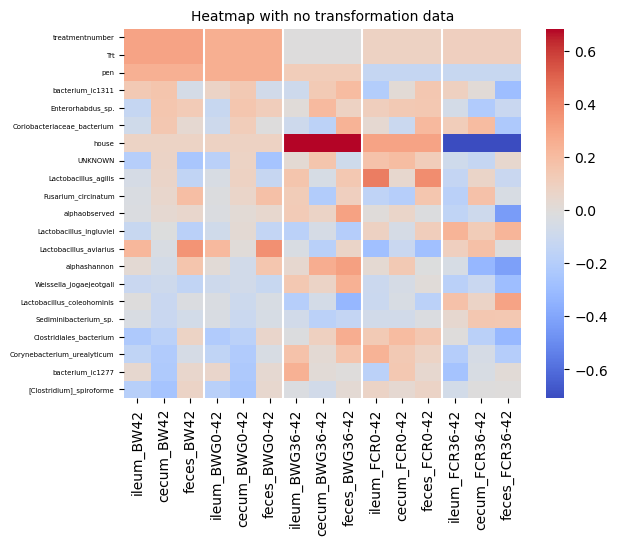

In [321]:
column_order = ['ileum_BW42', 'cecum_BW42', 'feces_BW42', 
         'ileum_BWG0-42', 'cecum_BWG0-42', 'feces_BWG0-42',
         'ileum_BWG36-42', 'cecum_BWG36-42', 'feces_BWG36-42',
         'ileum_FCR0-42', 'cecum_FCR0-42', 'feces_FCR0-42',
         'ileum_FCR36-42', 'cecum_FCR36-42', 'feces_FCR36-42']

# Crear el heatmap utilizando seaborn
fig, ax = plt.subplots()
ht1 = sns.heatmap(filtered_df[column_order],ax = ax, cmap='coolwarm')
plt.xticks(fontsize=10)
plt.yticks(fontsize=5)
ax.axvline(3, color='w')
ax.axvline(6, color='w')
ax.axvline(9, color='w')
ax.axvline(12, color='w')
ax.set_title('Heatmap with no transformation data', fontsize=10)




plt.show()

## CLR transformation data

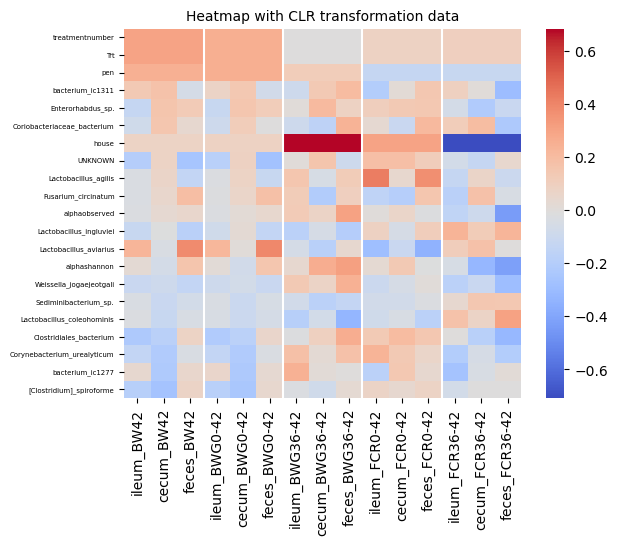

In [322]:
column_order = ['ileum_BW42', 'cecum_BW42', 'feces_BW42', 
         'ileum_BWG0-42', 'cecum_BWG0-42', 'feces_BWG0-42',
         'ileum_BWG36-42', 'cecum_BWG36-42', 'feces_BWG36-42',
         'ileum_FCR0-42', 'cecum_FCR0-42', 'feces_FCR0-42',
         'ileum_FCR36-42', 'cecum_FCR36-42', 'feces_FCR36-42']

# Crear el heatmap utilizando seaborn
fig, ax = plt.subplots()
ht2 = sns.heatmap(filtered_df_clr[column_order],ax = ax, cmap='coolwarm')
plt.xticks(fontsize=10)
plt.yticks(fontsize=5)
ax.axvline(3, color='w')
ax.axvline(6, color='w')
ax.axvline(9, color='w')
ax.axvline(12, color='w')
ax.set_title('Heatmap with CLR transformation data', fontsize=10)



plt.show()

## LR transformation data

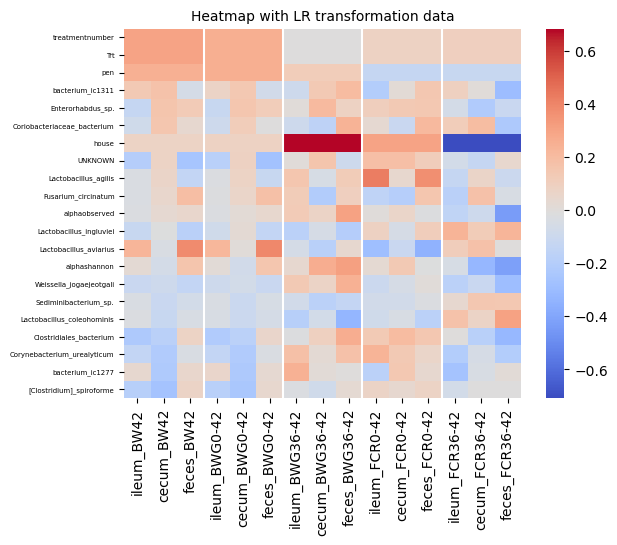

In [323]:
column_order = ['ileum_BW42', 'cecum_BW42', 'feces_BW42', 
         'ileum_BWG0-42', 'cecum_BWG0-42', 'feces_BWG0-42',
         'ileum_BWG36-42', 'cecum_BWG36-42', 'feces_BWG36-42',
         'ileum_FCR0-42', 'cecum_FCR0-42', 'feces_FCR0-42',
         'ileum_FCR36-42', 'cecum_FCR36-42', 'feces_FCR36-42']


fig, ax = plt.subplots()
ht3 = sns.heatmap(filtered_df_lr[column_order],ax = ax, cmap='coolwarm')
plt.xticks(fontsize=10)
plt.yticks(fontsize=5)
ax.axvline(3, color='w')
ax.axvline(6, color='w')
ax.axvline(9, color='w')
ax.axvline(12, color='w')
ax.set_title('Heatmap with LR transformation data', fontsize=10)



plt.show()

In [346]:

# Definir una lista de las variables independientes
independientes = ['UNKNOWN',
 'bacterium_ic1277',
 'Lactobacillus_aviarius',
 'Bacteroides_plebeius',
 'Peptostreptococcus_sp.',
 'Enterococcus_cecorum',
 'Lactobacillus_coleohominis',
 'Helicobacter_pullorum',
 'Lactobacillus_agilis',
 'Prevotellaceae_bacterium',
 'Akkermansia_muciniphila',
 'Clostridiales_bacterium',
 'Odoribacter_sp.',
 'Fusobacterium_mortiferum',
 'Prevotella_sp.',
 'Anaerotignum_lactatifermentans',
 'Corynebacterium_urealyticum',
 'Lachnoclostridium_phocaeense',
 'Acinetobacter_sp.',
 'Campylobacter_lanienae',
 'Eubacterium_sp.',
 'Anaerostipes_butyraticus',
 'Prevotella_disiens',
 'Odoribacter_splanchnicus',
 'bacterium_ic1311',
 'Butyricicoccus_pullicaecorum',
 'Lactobacillus_saerimneri',
 'Clostridium_butyricum',
 'Massiliomicrobiota_timonensis',
 'Weissella_jogaejeotgali',
 '[Clostridium]_spiroforme',
 'bacterium_ic1391',
 'bacterium_ic1296',
 'Coriobacteriaceae_bacterium',
 'Streptococcus_pluranimalium',
 'Bacteroidales_bacterium',
 'Victivallis_vadensis',
 'Bacteroides_clarus',
 'Burkholderiales_bacterium',
 'Alistipes_inops',
 'Corynebacterium_aurimucosum',
 'Enterorhabdus_sp.',
 'Gordonibacter_urolithinfaciens',
 'bacterium_YE57',
 'Coprobacter_secundus',
 'poultry_manure',
 'Rikenella_microfusus',
 'Alistipes_obesi',
 'Faecalitalea_sp.',
 'Lactobacillus_ingluviei',
 'Sporosarcina_pasteurii',
 'Clostridium_sp.',
 'Intestinimonas_timonensis',
 'bacterium_QTYC46b',
 'Virgibacillus_soli',
 'Azospirillum_sp.',
 'Actinomycetales_bacterium',
 'Marinomonas_communis',
 'Peptostreptococcaceae_bacterium',
 'Bacillus_thermoamylovorans',
 'Eubacteriaceae_bacterium',
 'Corynebacterium_propinquum',
 'Sediminibacterium_sp.',
 'Sutterellaceae_bacterium',
 'Paenibacillus_motobuensis',
 'Bacillus_oleronius',
 'Tomitella_sp.',
 'Tissierella_sp.',
 'Alistipes_sp.',
 'Lachnospiraceae_bacterium',
 'Oligella_ureolytica',
 'Fusarium_circinatum',
 'Paenibacillus_fonticola',
 'Clostridium_jeddahense',
 'Bifidobacterium_subtile',
 'Candidatus_Arthromitus',
 'Trichoderma_gamsii',
 'Rhabdanaerobium_thermarum',
 'Algoriphagus_marincola',
 'Turicimonas_muris',
 'Prevotella_buccalis',
 'Lactobacillus_vaginalis',
 'Bdellovibrio_sp.','alphashannon',
 'alphaobserved']

# Definir una lista de las variables dependientes
dependientes = ['BW42',
 'FCR0-42',
 'FCR36-42',
 'BWG0-42',
 'BWG36-42']

# Iterar a través de cada variable dependiente
for dependiente in dependientes:
    print('Variable dependiente:', dependiente)
    
    # Iterar a través de cada variable independiente
    for independiente in independientes:
        print('Variable independiente:', independiente)
        
        # Seleccionar las columnas relevantes del DataFrame
        X = df_relation[independiente]
        y = df_relation[dependiente]
        
        # Ajustar el modelo de regresión lineal simple
        modelo = sm.OLS(y, sm.add_constant(X)).fit()
        
        # Imprimir los resultados del modelo
        print(modelo.summary())

Variable dependiente: BW42
Variable independiente: UNKNOWN
                            OLS Regression Results                            
Dep. Variable:                   BW42   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     3.626
Date:                Wed, 22 Feb 2023   Prob (F-statistic):             0.0585
Time:                        15:48:29   Log-Likelihood:                -1035.9
No. Observations:                 180   AIC:                             2076.
Df Residuals:                     178   BIC:                             2082.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

                            OLS Regression Results                            
Dep. Variable:                   BW42   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.242
Date:                Wed, 22 Feb 2023   Prob (F-statistic):              0.267
Time:                        15:48:29   Log-Likelihood:                -1037.1
No. Observations:                 180   AIC:                             2078.
Df Residuals:                     178   BIC:                             2085.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

                            OLS Regression Results                            
Dep. Variable:                   BW42   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.734
Date:                Wed, 22 Feb 2023   Prob (F-statistic):              0.190
Time:                        15:48:29   Log-Likelihood:                -1036.9
No. Observations:                 180   AIC:                             2078.
Df Residuals:                     178   BIC:                             2084.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

                            OLS Regression Results                            
Dep. Variable:                   BW42   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                  0.008999
Date:                Wed, 22 Feb 2023   Prob (F-statistic):              0.925
Time:                        15:48:29   Log-Likelihood:                -1037.7
No. Observations:                 180   AIC:                             2079.
Df Residuals:                     178   BIC:                             2086.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               2766.4747      5

                            OLS Regression Results                            
Dep. Variable:                FCR0-42   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.878
Date:                Wed, 22 Feb 2023   Prob (F-statistic):              0.172
Time:                        15:48:29   Log-Likelihood:                 325.97
No. Observations:                 180   AIC:                            -647.9
Df Residuals:                     178   BIC:                            -641.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

                            OLS Regression Results                            
Dep. Variable:                FCR0-42   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     4.128
Date:                Wed, 22 Feb 2023   Prob (F-statistic):             0.0437
Time:                        15:48:30   Log-Likelihood:                 327.09
No. Observations:                 180   AIC:                            -650.2
Df Residuals:                     178   BIC:                            -643.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.6345      0.003  

                            OLS Regression Results                            
Dep. Variable:                FCR0-42   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.4015
Date:                Wed, 22 Feb 2023   Prob (F-statistic):              0.527
Time:                        15:48:30   Log-Likelihood:                 325.23
No. Observations:                 180   AIC:                            -646.5
Df Residuals:                     178   BIC:                            -640.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.6366      0.003  

                            OLS Regression Results                            
Dep. Variable:                FCR0-42   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.1601
Date:                Wed, 22 Feb 2023   Prob (F-statistic):              0.689
Time:                        15:48:30   Log-Likelihood:                 325.11
No. Observations:                 180   AIC:                            -646.2
Df Residuals:                     178   BIC:                            -639.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1

                            OLS Regression Results                            
Dep. Variable:               FCR36-42   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.106
Date:                Wed, 22 Feb 2023   Prob (F-statistic):              0.294
Time:                        15:48:30   Log-Likelihood:                 133.70
No. Observations:                 180   AIC:                            -263.4
Df Residuals:                     178   BIC:                            -257.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

                            OLS Regression Results                            
Dep. Variable:               FCR36-42   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                   0.01004
Date:                Wed, 22 Feb 2023   Prob (F-statistic):              0.920
Time:                        15:48:30   Log-Likelihood:                 133.15
No. Observations:                 180   AIC:                            -262.3
Df Residuals:                     178   BIC:                            -255.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

                            OLS Regression Results                            
Dep. Variable:               FCR36-42   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.7050
Date:                Wed, 22 Feb 2023   Prob (F-statistic):              0.402
Time:                        15:48:31   Log-Likelihood:                 133.50
No. Observations:                 180   AIC:                            -263.0
Df Residuals:                     178   BIC:                            -256.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.9234      0.009    2

                            OLS Regression Results                            
Dep. Variable:               FCR36-42   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.060
Date:                Wed, 22 Feb 2023   Prob (F-statistic):              0.305
Time:                        15:48:31   Log-Likelihood:                 133.68
No. Observations:                 180   AIC:                            -263.4
Df Residuals:                     178   BIC:                            -257.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

                            OLS Regression Results                            
Dep. Variable:                BWG0-42   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.8503
Date:                Wed, 22 Feb 2023   Prob (F-statistic):              0.358
Time:                        15:48:31   Log-Likelihood:                -1032.7
No. Observations:                 180   AIC:                             2069.
Df Residuals:                     178   BIC:                             2076.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2719.9454 

                            OLS Regression Results                            
Dep. Variable:                BWG0-42   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.235
Date:                Wed, 22 Feb 2023   Prob (F-statistic):              0.268
Time:                        15:48:31   Log-Likelihood:                -1032.5
No. Observations:                 180   AIC:                             2069.
Df Residuals:                     178   BIC:                             2075.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    2

                            OLS Regression Results                            
Dep. Variable:                BWG0-42   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.270
Date:                Wed, 22 Feb 2023   Prob (F-statistic):              0.261
Time:                        15:48:31   Log-Likelihood:                -1032.5
No. Observations:                 180   AIC:                             2069.
Df Residuals:                     178   BIC:                             2075.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    2

                            OLS Regression Results                            
Dep. Variable:                BWG0-42   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                   0.09049
Date:                Wed, 22 Feb 2023   Prob (F-statistic):              0.764
Time:                        15:48:32   Log-Likelihood:                -1033.1
No. Observations:                 180   AIC:                             2070.
Df Residuals:                     178   BIC:                             2077.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

                            OLS Regression Results                            
Dep. Variable:               BWG36-42   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.6941
Date:                Wed, 22 Feb 2023   Prob (F-statistic):              0.406
Time:                        15:48:32   Log-Likelihood:                -950.44
No. Observations:                 180   AIC:                             1905.
Df Residuals:                     178   BIC:                             1911.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  632.9728 

                            OLS Regression Results                            
Dep. Variable:               BWG36-42   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.8216
Date:                Wed, 22 Feb 2023   Prob (F-statistic):              0.366
Time:                        15:48:32   Log-Likelihood:                -950.37
No. Observations:                 180   AIC:                             1905.
Df Residuals:                     178   BIC:                             1911.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

                            OLS Regression Results                            
Dep. Variable:               BWG36-42   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     3.565
Date:                Wed, 22 Feb 2023   Prob (F-statistic):             0.0606
Time:                        15:48:32   Log-Likelihood:                -949.00
No. Observations:                 180   AIC:                             1902.
Df Residuals:                     178   BIC:                             1908.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  631.1739 

                            OLS Regression Results                            
Dep. Variable:               BWG36-42   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.222
Date:                Wed, 22 Feb 2023   Prob (F-statistic):              0.270
Time:                        15:48:33   Log-Likelihood:                -950.17
No. Observations:                 180   AIC:                             1904.
Df Residuals:                     178   BIC:                             1911.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             632.4570      3.567    1

In [345]:
list(df_relation.columns)

['sampleid',
 'fullsampleid',
 'kitid',
 'runid',
 'animalid',
 'samplelocation',
 'alphashannon',
 'alphaobserved',
 'kitid',
 'projectid',
 'age',
 'treatment',
 'treatmentnumber',
 'client',
 'animalid',
 'animaltype',
 'animalnumber',
 'house',
 'pen',
 'Block',
 'Trt',
 'BW42',
 'FCR0-42',
 'FCR36-42',
 'BWG0-42',
 'BWG36-42',
 'UNKNOWN',
 'bacterium_ic1277',
 'Lactobacillus_aviarius',
 'Bacteroides_plebeius',
 'Peptostreptococcus_sp.',
 'Enterococcus_cecorum',
 'Lactobacillus_coleohominis',
 'Helicobacter_pullorum',
 'Lactobacillus_agilis',
 'Prevotellaceae_bacterium',
 'Akkermansia_muciniphila',
 'Clostridiales_bacterium',
 'Odoribacter_sp.',
 'Fusobacterium_mortiferum',
 'Prevotella_sp.',
 'Anaerotignum_lactatifermentans',
 'Corynebacterium_urealyticum',
 'Lachnoclostridium_phocaeense',
 'Acinetobacter_sp.',
 'Campylobacter_lanienae',
 'Eubacterium_sp.',
 'Anaerostipes_butyraticus',
 'Prevotella_disiens',
 'Odoribacter_splanchnicus',
 'bacterium_ic1311',
 'Butyricicoccus_pullic